## Figure 7. General and optimal structures of pri-miRNAs.


In [1]:
import time
today = time.strftime('%Y-%m-%d')
name = 'S. Chan Baek'
print 'Last revised by %s at %s.' % (name, today)

Last revised by S. Chan Baek at 2024-01-26.


In [2]:
import os
HOME = '/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep'
SAVEPATH = '%s/%s/'%(HOME,time.strftime('%y%m%d'))
#if not os.path.exists(SAVEPATH):
#    os.makedirs(SAVEPATH)
print SAVEPATH
%cd $HOME

/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep/240126/
/casa/bsc/projects/2_Structure-of-pri/2007_paper_prep


In [45]:
from __future__ import division
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from matplotlib import gridspec, lines, colors
from scipy.stats import pearsonr, mannwhitneyu, sem
from os import listdir
import pandas as pd
import numpy as np
import re
%matplotlib inline

In [4]:
s1 = pd.read_csv('publication/TableS1__Pri-miRNAs_selected_for_SHAPE-MaP.csv',index_col=0)
s2 = pd.read_csv('publication/TableS2__Constructs_used_in_this_study.csv',index_col=0)
s3 = pd.read_csv('publication/TableS3_2__SHAPE_reactivity.csv',index_col=0)
s3.columns = range(1,126)
s3cnts = pd.read_csv('publication/TableS3_1__Read_counts.csv',index_col=0)
s3shan = pd.read_csv('publication/TableS3_3__Shannon_entropy.csv',index_col=0)
s3shan.columns = range(1,126)
s3shan = s3shan.fillna(0)
s4str = pd.read_csv('publication/TableS4_1__SHAPE-based_pri-miRNA_structures.csv',index_col=0)
s4str.columns = range(1,126)
s4 = pd.read_csv('publication/TableS4_2__Structural_features_of_pri-miRNAs.csv',index_col=0)
releffs = s4['Cleavage efficiency (MP)']
relhoms = s4['Cleavage homogeneity (MP)']
constseqs = s2['Construct sequence'].to_dict()
folded = list(s4.index)
print len(folded)

476


In [5]:
def get_pre_position(mir):
    constseq = constseqs[mir].replace('T','U')
    preseq = s1.loc[mir, 'Precursor']
    return constseq.find(preseq)+1, constseq.find(preseq)+len(preseq)

def split_ct(ctfile):
    infos = open(ctfile, 'rt').read()
    length = int(infos.split('\n')[0].strip().split()[0])
    rna = infos.split('\n')[0].strip().split()[-1]
    nstrt = infos.count(rna)
    splitinfos = []
    for i in range(nstrt):
        lines = infos.split('\n')[1+(1+length)*i:(1+length)*(i+1)]
        splitinfos.append([ tuple(map(int,l.strip().split()[4:6][::-1])) for l in lines ])
    return splitinfos

---
### A. General structure of pri-miRNAs

In [13]:
s4['Bulges'] = s4['5p bulges']+s4['3p bulges']

In [14]:
features = ['Stem length (bp)','Apical loop size (nt)',"3' basal segment length (nt)",'Mismatches','Bulges']
for feat in features:
    print feat, np.percentile(s4[feat],[25,75],interpolation='nearest')

Stem length (bp) [33 36]
Apical loop size (nt) [11 15]
3' basal segment length (nt) [ 2 14]
Mismatches [3 5]
Bulges [1 4]


### B. Optimal structure of pri-miRNA

In [17]:
OPT_STEM = [34,35,36]
OPT_LSTEM = [13]
OPT_LOOP = range(13,999)
OPT_MM = [0,1]
OPT_BS3 = range(5,999)

### C. Combination of optimal structures

In [18]:
features = ['Stem length (bp)','Lower stem length (bp)','Apical loop size (nt)','Mismatches','Bulges','Mismatch at -6',
            'bGWG at -10/-11',"3' basal segment length (nt)"]
mirfeat = defaultdict(list)
for m in folded:
    stlen,lslen,loop,mm,bg,mm6,bgwg,bs3 = s4.loc[m,features]
    mm = mm-mm6
    bg = bg-bgwg
    
    if stlen in OPT_STEM:
        mirfeat[m].append('stem')
    if lslen in OPT_LSTEM:
        mirfeat[m].append('lower stem')
    if mm in OPT_MM:
        mirfeat[m].append('mismatch')
    if loop in OPT_LOOP:
        mirfeat[m].append('loop')
    if bs3 in OPT_BS3:
        mirfeat[m].append('BS')
    if m not in mirfeat:
        mirfeat[m]=[]
print mirfeat['hsa-let-7a-1']

['stem', 'lower stem', 'mismatch', 'loop', 'BS']


In [25]:
CNTCUT = 6
allcoms = set([';'.join(vs) for vs in mirfeat.values()])
comcnts = Counter([';'.join(vs) for vs in mirfeat.values()])
suffcoms = [com for com in allcoms if comcnts[com]>=CNTCUT]
sortcoms = sorted(suffcoms,key=lambda x:comcnts[x])[::-1]
cs = ['#a1dab4','#41b6c4','#2c7fb8','#253494','#253494']
ys1 = [comcnts[com] for com in sortcoms]
ys1 = np.array(ys1)/len(folded)*100
tmpd = {0:'#a1dab4',1:'#a1dab4', 2:'#41b6c4', 3:'#2c7fb8', 4:'#253494', 5:'#253494'}
csl = [tmpd[len(com.split(';'))] for com in sortcoms]
labels = ['0-1','2','3','4-5']
print len(sortcoms), sum([comcnts[com] for com in suffcoms])

19 448


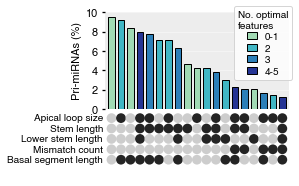

In [27]:
feats2 = ['loop','stem','lower stem','mismatch','BS']
named = {'loop':'Apical loop size','stem':'Stem length', 'lower stem':'Lower stem length',
         'mismatch':'Mismatch count','BS':'Basal segment length','bulge':'Bulge count'}

fig = plt.figure(figsize=(3.3,3))
gs = gridspec.GridSpec(5,1)
ax1 = plt.subplot2grid((5,1),(0,0),colspan=1,rowspan=3)
ax2 = plt.subplot2grid((5,1),(3,0),colspan=1,rowspan=2)
fig.subplots_adjust(hspace=.1)

l = len(feats2)
for i, mots in enumerate(sortcoms):
    colors = [ '#242424' if mot in mots.split(';') else '#cdcdcd' for mot in feats2 ]
    ax2.scatter([i]*l, range(l), s=95, color=colors, linewidth=0)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_ylim(-.6,len(feats2)+.5)
ax2.invert_yaxis()
ax2.set_xticks([]); ax2.set_yticks([])
for i,txt in zip(range(len(feats2)),feats2):
    ax2.text(-.9,i,named[txt],va='center',ha='right',fontsize=10)

for c,l in zip(cs,labels):
    ax1.bar([-1],[0],color=c,label=l,width=.7,edgecolor='k',lw=1)
ax1.legend(handlelength=1,title='No. optimal\nfeatures',labelspacing=.25,
           loc=(.7,.3))
ax1.set_ylim(0,10)

for ax in [ax1,ax2]:
    ax.set_xlim(-.7,len(ys1)-.3)
    ax.tick_params(bottom='off')
    
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_facecolor('#ededed')
ax1.bar(range(len(ys1)),ys1,color=csl,width=.7,edgecolor='k',lw=1,zorder=2)
ax1.set_ylabel('Pri-miRNAs (%)')
ax1.set_yticks(range(0,11,2))
ax1.yaxis.grid(ls='-',lw=.8,color='w')
#fig.savefig('combination.pdf',dpi=300)

### D-E. Cleavage efficiency and cleavage homogeneity

In [32]:
def parse_line(row):
    for s in row['attr'].split(';'):
        tag, value = s.split('=')
        row[tag] = value
    return row

def load_mirbase_annot():
    gff = 'publication/human_mirbase-v21.gff3'
    anntbl = pd.read_table(gff, header=12, sep='\t', usecols=[0,2,3,4,6,8], 
                           names=['chr','kind','start','end','strand','attr'])
    anntbl = anntbl.apply(parse_line, axis=1).drop(['attr'], axis=1)
    return anntbl

def drop_family(ml):
    dupls = []
    for fam in famgrps:
        overlap = [m for m in famgrps[fam] if m in ml]
        
        if len(overlap)>=2:
            dupls.extend(overlap[1:])
    return [m for m in ml if m not in dupls]

anntbl = load_mirbase_annot()
annpri = anntbl[anntbl['kind']=='miRNA_primary_transcript'].set_index('Name')
annmat = anntbl[anntbl['kind']=='miRNA'].set_index('ID')

primat = {}
for pri, row in annpri.iterrows():
    matureDerives = anntbl[anntbl['Derives_from']==row['ID']]
    primat[pri] = matureDerives['ID'].tolist()
print primat['hsa-mir-320a']

namedict = annpri.reset_index().set_index('Alias')['Name'].to_dict()
print namedict['MI0022705']

dbf = 'publication/mirgenedb_v2.gff'
db = pd.read_table(dbf, sep='\t', header=2, usecols=[0,2,3,4,6,8], 
                     names=['chr','type','start','end','strand','info'])
db['db id'] = db['info'].apply(lambda x:x.split(';')[0].split('=')[1]) # Hsa-Let-7-P1_pre
db['db name'] = db['db id'].apply(lambda x:x.split('_')[0]) # Hsa-Let-7-P1
dbpre = db[db['type']=='pre_miRNA'].copy()
dbpre['family'] = db['db name'].apply(lambda x:'-'.join(x.split('-')[1:3]))
dbpre = dbpre[dbpre['info'].apply(lambda x:x.find('Alias')>=0)]
dbpre['mb name'] = dbpre['info'].apply(lambda x:namedict[x.split(';')[1].split('=')[1]])
allmirs = dbpre['mb name'].tolist()
famgrps = {fam:grp['mb name'].tolist() for fam,grp in dbpre.groupby('family')}
print famgrps['Let-7']

['MIMAT0000510']
hsa-mir-6859-1
['hsa-let-7a-2', 'hsa-let-7i', 'hsa-let-7e', 'hsa-let-7c', 'hsa-let-7a-3', 'hsa-let-7b', 'hsa-let-7g', 'hsa-let-7a-1', 'hsa-let-7f-1', 'hsa-let-7d', 'hsa-mir-98', 'hsa-let-7f-2']


In [35]:
bins = [(0,1),(2,2),(3,3),(4,6)]
labels = ['0-1',2,3,'4-5']
mls = [drop_family([m for m in folded if lb<=len(mirfeat[m])<=ub]) for lb,ub in bins]
cs = ['#a1dab4','#41b6c4','#2c7fb8','#253494','#253494']
print map(len,mls) 

[93, 102, 65, 43]


In [36]:
data = [ [releffs[m] for m in ml] for ml in mls ]
print mannwhitneyu(data[-1],data[0])[1]*2
print mannwhitneyu(data[-1],data[1])[1]*2
print mannwhitneyu(data[-1],data[2])[1]*2

8.432672424100323e-08
0.00016112220046057415
0.20712937915631235


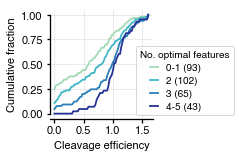

In [38]:
data = [ [d if d<1.6 else 1.6 for d in ds] for ds in data ]
bins = np.arange(-.01,1.62,.02)
xs = np.arange(0,1.61,.02)

fig, ax = plt.subplots(1, 1, figsize=(1.85,2))
for ds,l,c in zip(data,labels,cs):
    vs, ts = np.histogram(ds,bins=bins)
    ax.plot(xs, vs.cumsum()/vs.sum(), lw=1.8, label='%s (%s)       '%(l,len(ds)),color=c)
ax.spines['left'].set_bounds(0,1)
ax.set_xlabel('Cleavage efficiency')
ax.set_ylabel('Cumulative fraction')
ax.set_xticks([0,.5,1,1.5])
ax.set_yticks(np.arange(0,1.1,.25))
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=.8,loc=(.84,.03),title='No. optimal features',labelspacing=.4)
#fig.savefig('eff.pdf')#,dpi=300)

In [39]:
data = [ [relhoms[m] for m in ml] for ml in mls ]
print mannwhitneyu(data[-1],data[0])[1]*2
print mannwhitneyu(data[-1],data[1])[1]*2
print mannwhitneyu(data[-1],data[2])[1]*2

7.095594921440403e-10
1.6049248444906648e-05
0.06971179453351256


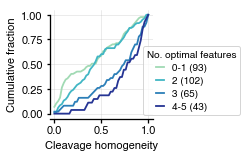

In [40]:
bins = np.arange(-.01,1.02,.02)
xs = np.arange(0,1.01,.02)

fig, ax = plt.subplots(1, 1, figsize=(1.85,2))
for ds,l,c in zip(data,labels,cs):
    vs, ts = np.histogram(ds,bins=bins)
    ax.plot(xs, vs.cumsum()/vs.sum(), lw=1.8, label='%s (%s)       '%(l,len(ds)),color=c)
ax.spines['left'].set_bounds(0,1)
ax.set_xlabel('Cleavage homogeneity')
ax.set_ylabel('Cumulative fraction')
ax.set_yticks(np.arange(0,1.1,.25))
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=.8,loc=(.9,.03),title='No. optimal features',labelspacing=.4)
#fig.savefig('hom.pdf')#,dpi=300)

### F-G. Conservation and cellular expression of miRNA groups classified in (C)

In [33]:
aqseq = pd.read_table('publication/Kim2019_aqseq_rpm.tsv',index_col=0)
aqseq = aqseq / aqseq.sum() * 10**6
aqseq.head(1)

,hek293t_1,hek293t_2,hela_1,hela_2
hsa-let-7a-2-3p,0.0,0.0,14.621023,16.57337


In [42]:
def get_mature_exp(pri,exptbl):
    mats = primat[pri]
    matexp = []
    for mat in mats:
        matname = annmat.loc[mat,'Name']
        if matname in exptbl.index:
            matexp.append((exptbl.loc[matname]+1).tolist())
    if matexp:
        return max(matexp,key=lambda x:np.average(x))
    return [1,1]
aqseqrpms = { p:map(np.log2,get_mature_exp(p,aqseq)) for p in folded }

In [46]:
def get_phylop_scores(chrom, start, end, path):
    phystarts = [ int(f.split('.')[0]) for f in listdir('%s/%s'%(path, chrom)) 
                  if f.endswith('.gz') ]
    init = sorted([ s for s in phystarts if s<=start ])[-1]
    if start<max(phystarts):
        nextst = sorted([ s for s in phystarts if s>start])[0]
    else: nextst = end
    rels, rele = start-init, end-init
    phys = open('%s/%s/%s.phylop.gz'%(path, chrom,init), 'rt').read().strip().split('\n')
    if len(phys) <= rels:
        if nextst >= end:
            return ['-']*(end-start+1)
        else:
            return ['-']*(nextst-start) + get_phylop_scores(chrom, nextst, end, path)
    elif len(phys) > rele:
        return map(float, phys[rels:rele+1])
    else: # rels < len(phys) <= rele
        return map(float, phys[rels:]) + get_phylop_scores(chrom, init+len(phys), end,path)

def get_mature_conserv(pri, path):
    mats = primat[pri]
    matcons = []
    for mat in mats:
        ch, st, en = annmat.loc[mat,['chr','start','end']]
        cons = [ c for c in get_phylop_scores(ch, st, en, path) if c!='-' ]
        if cons:
            matcons.append(np.average(cons))
    if matcons:
        return max(matcons)
    return -999

path100 = '/casa/bsc/databases/human/phyloP100way'
matcons100 = { p:get_mature_conserv(p,path100) for p in folded}

In [47]:
data = [ [np.average(aqseqrpms[m]) for m in ml] for ml in mls ]
print mannwhitneyu(data[-1],data[0])[1]*2
print mannwhitneyu(data[-1],data[1])[1]*2
print mannwhitneyu(data[-1],data[2])[1]*2

0.013114910128930986
0.5959004142049428
0.6832881787897143


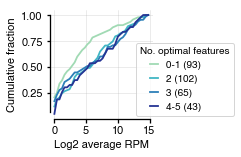

In [48]:
bins = np.arange(-.2,15.3,.4)
xs = np.arange(0,15.1,.4)
fig, ax = plt.subplots(1, 1, figsize=(1.85,2))
for ds,i,c in zip(data,labels,cs):
    vs, ts = np.histogram(ds,bins=bins)
    ax.plot(xs, vs.cumsum()/vs.sum(), lw=1.8, label='%s (%s)       '%(i,len(ds)),color=c)
ax.spines['left'].set_bounds(.06,1)
ax.spines['bottom'].set_bounds(0,15)
ax.set_xlabel('Log2 average RPM')#\n(Hela & 293T; Kim et al., 2019)')
ax.set_ylabel('Cumulative fraction')
ax.set_xticks(range(0,16,5))
ax.set_yticks(np.arange(.25,1.1,.25))
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=.8,loc=(.84,.03),title='No. optimal features')
#fig.savefig('expression_aqseq.pdf')#,dpi=300)

In [49]:
data = [ [matcons100[m] for m in ml if matcons100[m]>-999] for ml in mls ]
print mannwhitneyu(data[-1],data[0])[1]*2
print mannwhitneyu(data[-1],data[1])[1]*2
print mannwhitneyu(data[-1],data[2])[1]*2

0.00042490575955278525
0.01737176862011903
0.08102975514762313


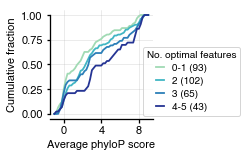

In [50]:
data = [ [d if d<9 else 9 for d in ds] for ds in data ]
bins = np.arange(-1.1,9.11,.2)
xs = np.arange(-1,9.1,.2)
#print map(len,data)

fig, ax = plt.subplots(1, 1, figsize=(1.85,2))
for ds,l,c in zip(data,labels,cs):
    vs, ts = np.histogram(ds,bins=bins)
    ax.plot(xs, vs.cumsum()/vs.sum(), lw=1.8, label='%s (%s)       '%(l,len(ds)),color=c)
ax.spines['left'].set_bounds(0,1)
ax.set_xlabel('Average phyloP score')
ax.set_ylabel('Cumulative fraction')
ax.set_xticks(range(0,9,4))
ax.set_yticks(np.arange(0,1.1,.25))
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=.8,loc=(.9,.03),title='No. optimal features',labelspacing=.4)
#fig.savefig('conserve99.pdf')#,dpi=300)

### S6

In [51]:
dgcrf = 'publication/Nguyen2018_rpm.csv'
dgcrtbl = pd.read_table(dgcrf, index_col=0, sep='\t')#.astype(int)
dgcrtbl['WT'] = dgcrtbl[['WT2', 'WT3']].mean(axis=1)
dgcrtbl['C352A'] = dgcrtbl[['C352A2','C352A3']].mean(axis=1)
dgcrtbl['P351A'] = dgcrtbl[['P351A2', 'P351A3']].mean(axis=1)
dgcrtbl['ALA'] = dgcrtbl[['ALA-2', 'ALA-3']].mean(axis=1)
dgcrtbl['FC'] = ((dgcrtbl['P351A']+.1) / (dgcrtbl['WT']+.1)).apply(np.log2)
cut = sorted(dgcrtbl['WT'])[-250]
dgcrsub = dgcrtbl[dgcrtbl['WT']>=cut]
dgcrsub = dgcrsub.reindex([m for m in dgcrsub.index if m.count('-')==2])
print len(dgcrsub)

165


In [53]:
ms0 = s4[s4['Apical loop size (nt)']>=13].index
ms1 = s4[s4['Apical loop size (nt)']<=9].index
fc0 = [dgcrsub.loc[m,'FC'] for m in ms0 if m in dgcrsub.index]
fc1 = [dgcrsub.loc[m,'FC'] for m in ms1 if m in dgcrsub.index]
print len(fc0), len(fc1)
print mannwhitneyu(fc0,fc1)[1]*2

66 23
0.023043282144479246


In [54]:
mls = [ms0,ms1]
bins = np.arange(-4.1,2.11,.2)
data = [ [dgcrsub.loc[m,'FC'] for m in ml if m in dgcrsub.index] for ml in mls ]
data = [ [c if c>-4 else -4 for c in cs] for cs in data ]
xs = np.arange(-4,2.1,.2)
cs = 'tab:red #424242'.split()
labels = ['Loop size    13','Loop size    9']
print map(len,data)

[66, 23]


Text(-0.5,0.4,u'p = 0.023')

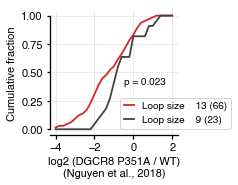

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(2.3,2.3))
for ds,l,c in zip(data,labels,cs):
    vs, ts = np.histogram(ds,bins=bins)
    ax.plot(xs, vs.cumsum()/vs.sum(), lw=1.8, label='%s (%s)'%(l,len(ds)),color=c)
ax.spines['left'].set_bounds(0,1)
ax.set_xlabel('log2 (DGCR8 P351A / WT)\n(Nguyen et al., 2018)')
ax.set_ylabel('Cumulative fraction')
ax.set_xticks(range(-4,3,2))
ax.set_yticks(np.arange(0,1.1,.25))
ax.grid(ls='-',lw=.5)
ax.legend(handlelength=1,loc=(.55,.05))
ax.text(-.5,.4,'p = 0.023')
#fig.savefig(resultpath+'221111_dgcr8.pdf')#,dpi=300)